### Урок 7. Интерпретация прогнозов модели (SHAP) - объясняем поведение модели на отдельных наблюдениях

#### Домашнее задание

- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


Датасет загружен по ссылке: https://www.kaggle.com/fedesoriano/heart-failure-prediction

In [5]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [6]:
path = '/gdrive/MyDrive/MLBI/lesson_7/'

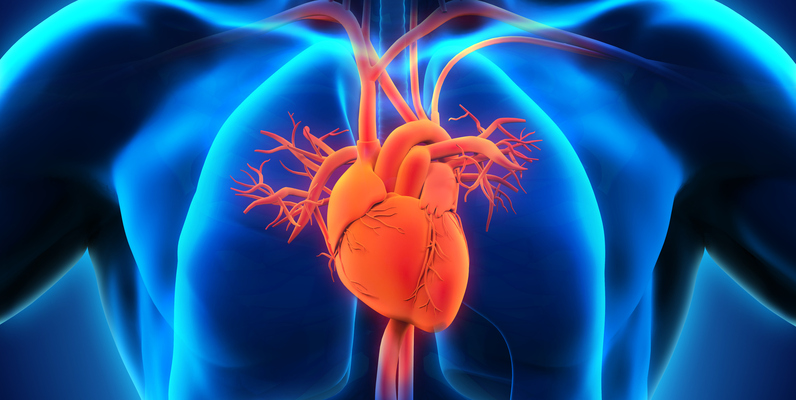

In [7]:
from IPython.display import Image
Image(path+"dataset-cover.jpg", width = 1200)

Сердечно-сосудистые заболевания (ССЗ) являются причиной смерти номер 1 во всем мире, унося, по оценкам, 17,9 миллиона жизней ежегодно, что составляет 31 % всех смертей во всем мире. Четыре из 5 смертей от ССЗ происходят в результате сердечных приступов и инсультов, и одна треть этих смертей происходит преждевременно у людей в возрасте до 70 лет. Сердечная недостаточность является распространенным событием, вызванным ССЗ, и этот набор данных содержит 11 признаков, которые можно использовать для прогнозирования возможного заболевания сердца.\
Люди с сердечно-сосудистыми заболеваниями или с высоким сердечно-сосудистым риском (из-за наличия одного или нескольких факторов риска, таких как гипертония, диабет, гиперлипидемия или уже установленное заболевание) нуждаются в раннем выявлении и лечении, в которых модель машинного обучения может оказать большую помощь.


Информация о признаках.

1. Age - Возраст: возраст пациента [лет]
2. Sex - Пол: пол пациента\
M: Мужчина\
F: Женщина
3. ChestPainType - Тип боли в груди:\
TA: Типичная стенокардия\
ATA: Атипичная стенокардия \
NAP: Боль неангинозного характера\
ASY: Бессимптомный
4. RestingBP - Артериальное давление в состоянии покоя: [мм рт.ст.]
5. Cholesterol - Холестерин: сывороточный холестерин [мм/дл]
6. FastingBS - Уровень сахара в крови натощак: уровень сахара в крови натощак \
1: если уровень сахара в крови натощак > 120 мг/дл\
0: в противном случае
7. RestingECG - Электрокардиограмма в состоянии покоя:\
Normal: Нормальный\
ST: с аномалией зубца ST-T (инверсии зубца T и/или подъем или понижение ST > 0,05 мВ)\
LVH: с вероятной или определенной гипертрофией левого желудочка по критериям Estes
8. MaxHR - Максимальная частота сердечных сокращений: [Числовое значение от 60 до 202]
9. ExerciseAngina - Стенокардия, вызванная физической нагрузкой: \
Y: да \
N: нет
10. Oldpeak - Часто является признаком ишемии миокарда, основной причиной которой является коронарная недостаточность:\
Глубина впадины сегмента ST на кардиограмме в мм
11. ST_Slope -  наклон сегмента ST (Нормальный сегмент ST имеет небольшую вогнутость вверх. Плоские, наклонные или вдавленные сегменты ST могут указывать на ишемию коронарных артерий.):\
Up: upsloping \
Flat: flat\
Down: downsloping
12. HeartDisease - Болезнь сердца (выходной класс):\
1: обнаружены болезни сердца\
0: болезни нет


In [8]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import itertools
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import plotly.figure_factory as ff

%matplotlib inline


Посмотрим на загруженные данные

In [9]:
df = pd.read_csv(path+'heart.csv')
df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Посмотрим на основные статистические данные:

In [11]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Проверим пропуски в датасете:

In [12]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Пропуски отсутствуют

Посмторим на целевую переменную:

1    508
0    410
Name: HeartDisease, dtype: int64

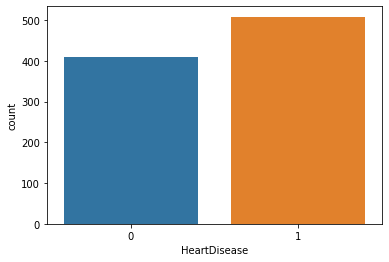

In [13]:
sns.countplot(x="HeartDisease", data=df)
df['HeartDisease'].value_counts()

Как видно из графика целевая переменная сбалансирована

Посмотрим на распределение признаков:

In [14]:
df_num_features = df.select_dtypes(include=['int64', 'float64'])

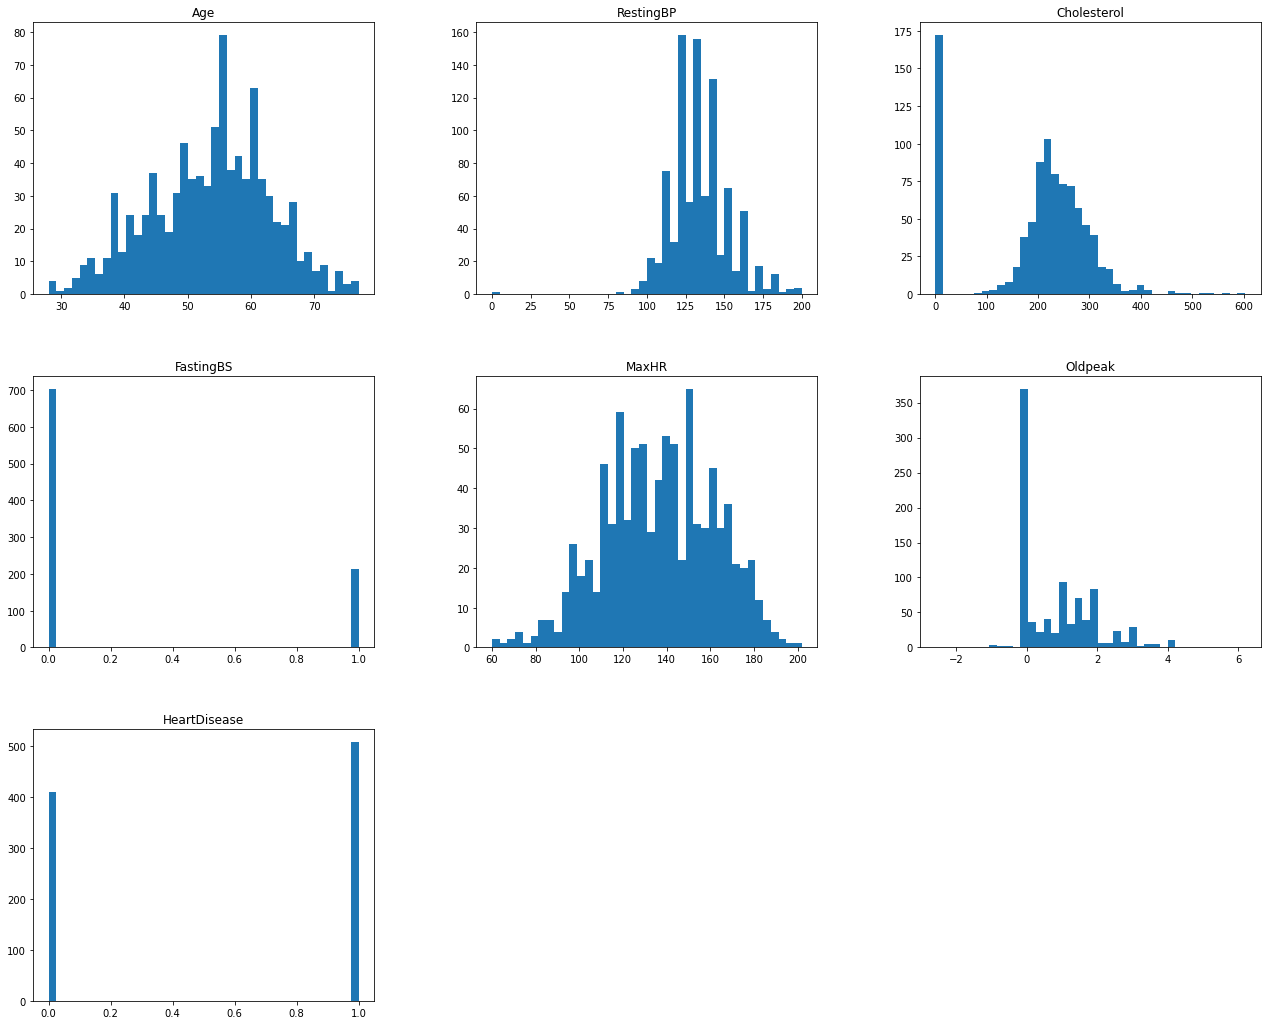

In [15]:
df_num_features.hist(figsize=(22, 18), bins=40, grid = False);

Признак 'Cholesterol' скорее всего не может быть равен 0

In [16]:
df['Cholesterol'].value_counts()

0      172
254     11
223     10
220     10
230      9
      ... 
355      1
354      1
353      1
349      1
603      1
Name: Cholesterol, Length: 222, dtype: int64

In [17]:
# Add histogram data
x1 = df["RestingBP"]
x2 = df["Cholesterol"]
x3 = df["MaxHR"]

# Group data together
hist_data = [x1, x2, x3]

group_labels = ['RestingBP', 'Cholesterol', 'MaxHR']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=10)
fig.show()


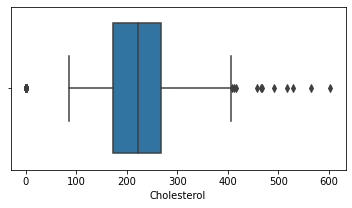

In [18]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Cholesterol'], whis=1.5)

plt.xlabel('Cholesterol')
plt.show()

Значение признака Cholesterol равное 0 заменим на медиану.

Построим корреляционную матрицу:

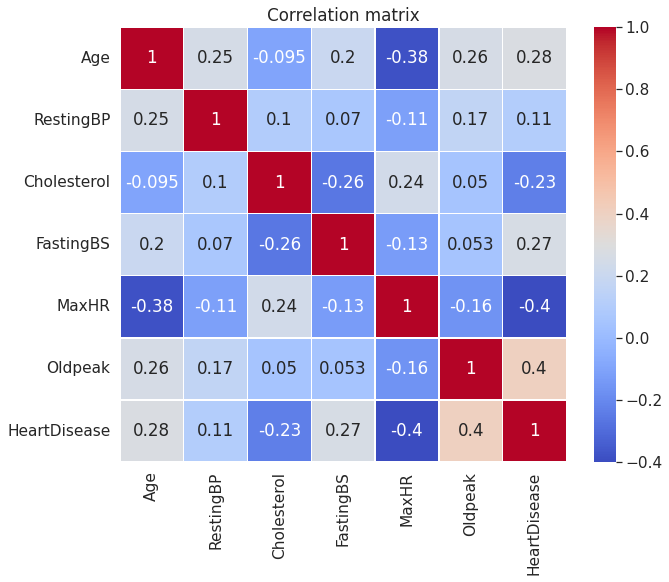

In [19]:
plt.figure(figsize = (10, 8))

sns.set(font_scale=1.4)
sns.heatmap(df.corr().round(3), annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

К полям 'Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak' применим StandardScaler

Признаки 'Sex', 'ExerciseAngina' из категориальных переведем в бинарные

Признаки 'ChestPainType', 'RestingECG', 'ST_Slope' приведем к dummies переменным

Признак 'FastingBS' оставим без изменений

In [20]:
df.loc[df['Cholesterol'] == 0, 'Cholesterol'] = df['Cholesterol'].median()

In [21]:
col_names = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
features = df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [22]:
df[col_names] = features
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,M,ATA,0.410909,0.897407,0,Normal,1.382928,N,-0.832432,Up,0
1,-0.478484,F,NAP,1.491752,-1.122849,0,Normal,0.754157,N,0.105664,Flat,1
2,-1.751359,M,ATA,-0.129513,0.786200,0,ST,-1.525138,N,-0.832432,Up,0
3,-0.584556,F,ASY,0.302825,-0.492677,0,Normal,-1.132156,Y,0.574711,Flat,1
4,0.051881,M,NAP,0.951331,-0.844832,0,Normal,-0.581981,N,-0.832432,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,-0.902775,M,TA,-1.210356,0.434046,0,Normal,-0.188999,N,0.293283,Flat,1
914,1.536902,M,ASY,0.627078,-0.881901,1,Normal,0.164684,N,2.357094,Flat,1
915,0.370100,M,ASY,-0.129513,-2.031038,0,Normal,-0.857069,Y,0.293283,Flat,1
916,0.370100,F,ATA,-0.129513,-0.084919,0,LVH,1.461525,N,-0.832432,Flat,1


In [23]:
binary_to_numbers = {'F': 0, 'M': 1}

df['Sex'] = df['Sex'].replace(binary_to_numbers)

In [24]:
binary_to_numbers = {'N': 0, 'Y': 1}

df['ExerciseAngina'] = df['ExerciseAngina'].replace(binary_to_numbers)

In [34]:
df = pd.get_dummies(df, columns=['ChestPainType', 'RestingECG', 'ST_Slope'])


In [35]:
df

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,-1.433140,1,0.410909,0.897407,0,1.382928,0,-0.832432,0,0,1,0,0,0,1,0,0,0,1
1,-0.478484,0,1.491752,-1.122849,0,0.754157,0,0.105664,1,0,0,1,0,0,1,0,0,1,0
2,-1.751359,1,-0.129513,0.786200,0,-1.525138,0,-0.832432,0,0,1,0,0,0,0,1,0,0,1
3,-0.584556,0,0.302825,-0.492677,0,-1.132156,1,0.574711,1,1,0,0,0,0,1,0,0,1,0
4,0.051881,1,0.951331,-0.844832,0,-0.581981,0,-0.832432,0,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,-0.902775,1,-1.210356,0.434046,0,-0.188999,0,0.293283,1,0,0,0,1,0,1,0,0,1,0
914,1.536902,1,0.627078,-0.881901,1,0.164684,0,2.357094,1,1,0,0,0,0,1,0,0,1,0
915,0.370100,1,-0.129513,-2.031038,0,-0.857069,1,0.293283,1,1,0,0,0,0,1,0,0,1,0
916,0.370100,0,-0.129513,-0.084919,0,1.461525,0,-0.832432,1,0,1,0,0,1,0,0,0,1,0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                918 non-null    float64
 1   Sex                918 non-null    int64  
 2   RestingBP          918 non-null    float64
 3   Cholesterol        918 non-null    float64
 4   FastingBS          918 non-null    int64  
 5   MaxHR              918 non-null    float64
 6   ExerciseAngina     918 non-null    int64  
 7   Oldpeak            918 non-null    float64
 8   HeartDisease       918 non-null    int64  
 9   ChestPainType_ASY  918 non-null    uint8  
 10  ChestPainType_ATA  918 non-null    uint8  
 11  ChestPainType_NAP  918 non-null    uint8  
 12  ChestPainType_TA   918 non-null    uint8  
 13  RestingECG_LVH     918 non-null    uint8  
 14  RestingECG_Normal  918 non-null    uint8  
 15  RestingECG_ST      918 non-null    uint8  
 16  ST_Slope_Down      918 non

In [37]:
X = df.drop('HeartDisease', 1)

In [38]:
y = df['HeartDisease']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [40]:
model = xgb.train({"learning_rate": 0.01}, 
                      xgb.DMatrix(X_train, label=y_train), 100)

In [31]:
!pip install shap

     |████████████████████████████████| 371 kB 4.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509254 sha256=3f442735f30654b9ee6410efbc42b2cea159a9bf80f215c737d06bc2a79d87a4
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [32]:
import shap

In [41]:
explainer_xgb = shap.TreeExplainer(model)

In [42]:
shap_values_xgb = explainer_xgb.shap_values(X_test)

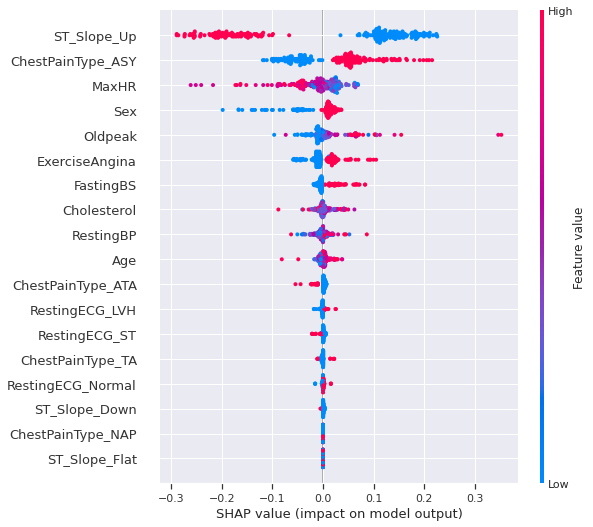

In [45]:
# summarize the effects of all the features
shap.summary_plot(shap_values_xgb, X_test)

На графике показано влияние признаков на принятие решения о наличии заболевания или его отсутствии. Например: признак "ST_Slope_Up" скорее вносит большее влияние за принятие решения об отутствии заболевания. А признак "ChestPainType_ASY" скорее больше влияет на принятие решения о наличии болезни.  

In [44]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[0,:], X_test.iloc[0,:])

Решение для конкретного пациента: Вероятность принятия решения о наличии болезни сердца достаточна велика (высокая оценка = 0,77). На повышение оценки влияли следующие факторы - ST_Slope_Up равный 0 (отсутствие положительного наклона сегмента ST на кардиограмме, наличие бессимптомных болей в груди (ChestPainType_ASY равный 1), уровень сазара в кррови болоее 120 г/дл (Fasting_DS равный 1), артериальное давление (RestingBP). На уменьшение оценки влияли следующие признаки -  Максимаьный пульс (MaxHR), значение Oldpeak и отутствие стенокардии. Но влияния этих признаков было в явном недостаточно, что бы отнести человека к здоровым. 

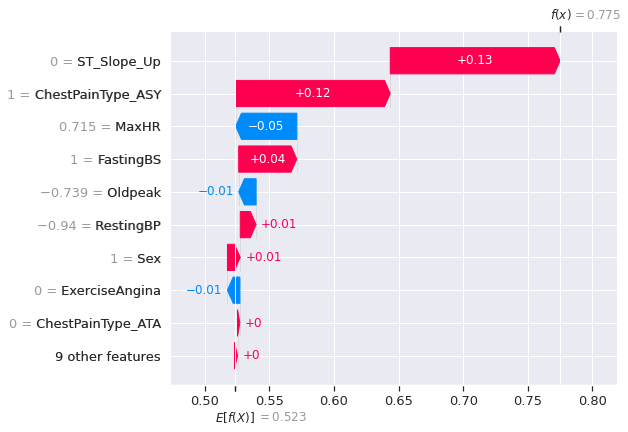

In [47]:
shap_values_all = explainer_xgb(X_test)

shap.initjs() # для работы в колаборатории 
shap.plots.waterfall(shap_values_all[0])

На графике представлены теже самые данные только в другом виде.

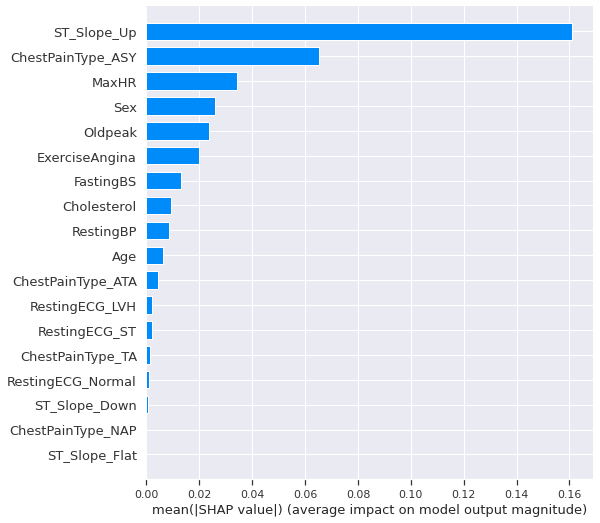

In [46]:
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar")

На графике выше показано влияние признаков по весам векторов Шепли. 

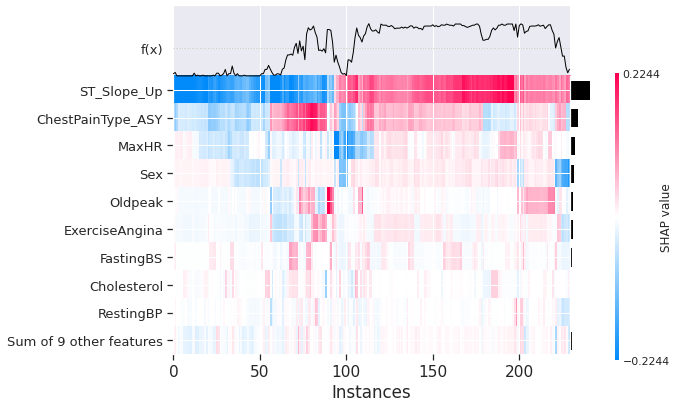

In [48]:
shap.initjs() # для работы в колаборатории 

shap.plots.heatmap(shap_values_all)

Тепловая диаграамма- так же показывае по всем признакам степень их влияния. Видно, что максимальное влияние оказывает признак ST_Slope_UP (наличие или отутствие поожительного наклона сегмента ST) и наличие или отутствие бессимптомных болей в груди.

In [50]:
shap.initjs()
n = 100
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[:n,:], X_test.iloc[:n,:])

И для другой модели классификации так же выведем такие же графики:

In [51]:
rforest = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
rforest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

Using 688 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/230 [00:00<?, ?it/s]

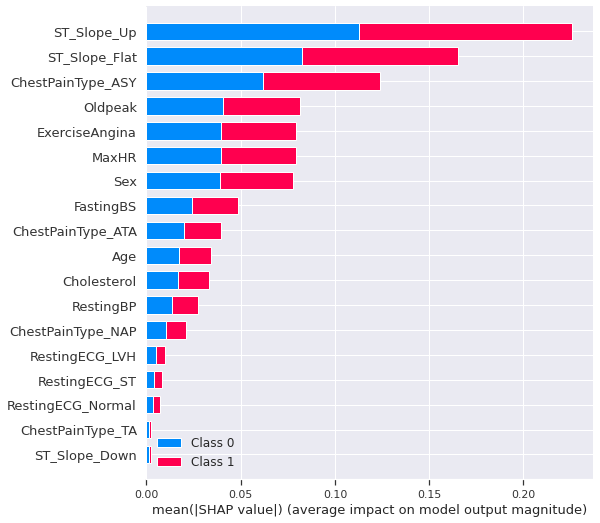

In [53]:
shap.initjs()
explainer = shap.KernelExplainer(rforest.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [47]:
shap.initjs()
explainer = shap.KernelExplainer(rforest.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

Using 688 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/230 [00:00<?, ?it/s]

In [50]:
shap.initjs()
shap_values = explainer.shap_values(X_test.iloc[0,:])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[0,:])